In [1]:
# libraries
import os
import pandas as pd 
import seaborn as sns
import numpy as np
import warnings
import random
import cv2
from threading import Thread
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

import keras
import tensorflow as tf

from keras import models, layers
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential, Model
from keras.layers import Conv2D, Input, Dropout, AveragePooling2D, Flatten, MaxPooling2D, Dense, GlobalAveragePooling2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2024-08-20 10:32:15.213934: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 10:32:15.214031: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 10:32:15.355097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
images_path = '/kaggle/input/sign-language/KSL-dataset/Images'
test_path = '/kaggle/input/sign-language/KSL-dataset/Test.csv'
train_path = '/kaggle/input/sign-language/KSL-dataset/Train.csv'

# **Exploratory analysis of training dataset**
## 1.**Train data**

In [3]:
train_df = pd.read_csv(train_path)
train_df.head()

,img_IDS,Label
0,ImageID_33HMDMJ3,Temple
1,ImageID_V5POEX4O,Church
2,ImageID_89CCCCW6,Enough/Satisfied
3,ImageID_GNJXOWX5,Me
4,ImageID_7Q9LOP7R,Love


In [4]:
# different classes of images

train_df['Label'].value_counts()

Label
Enough/Satisfied    695
Seat                695
Mosque              695
Temple              694
Church              694
Love                694
Me                  694
You                 694
Friend              694
Name: count, dtype: int64

In [5]:
train_df.shape

(6249, 2)

> Training images constitutes of 6,294 images  with 9 different classes.

**Sample images**

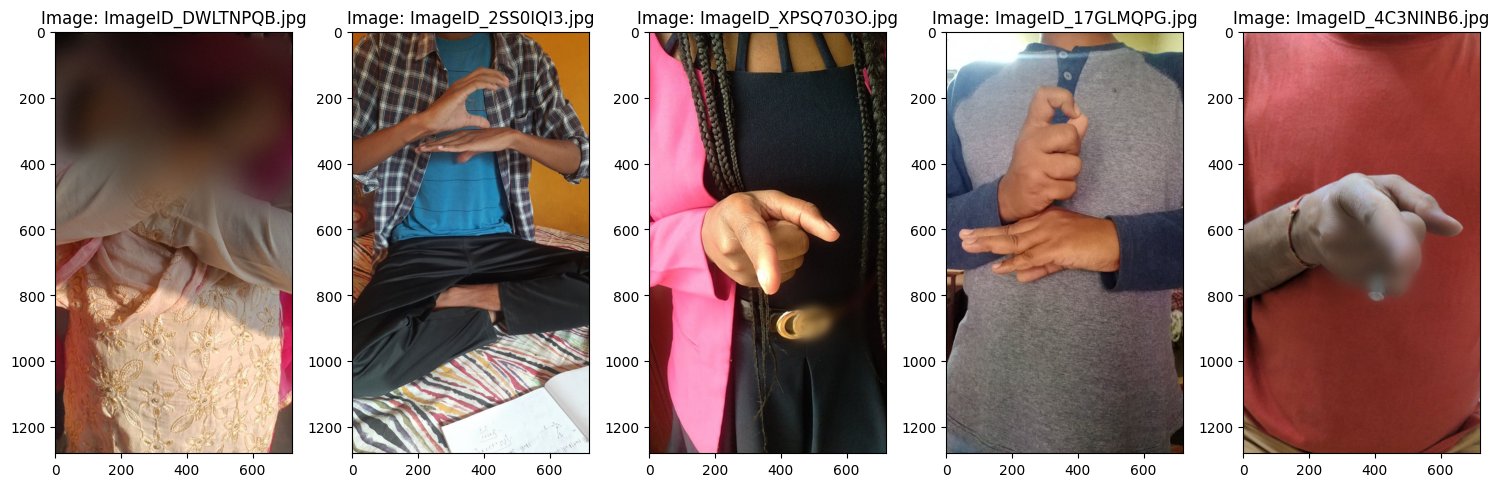

In [6]:
images = [f for f in os.listdir(images_path) if f.endswith(('.jpg'))]
random_images = random.sample(images, 5)

plt.figure(figsize=(15, 10))
for i, image_file in enumerate(random_images):
    img_path = os.path.join(images_path, image_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Image: {image_file}')
    plt.axis('on')
plt.tight_layout()
plt.show()

From the sample visulization, all the images bearing different sign languages have varying sizes. Some images are larger widths or heights than the others.

**Image mapping to corresponding labels**

In [7]:
class KSL:
    def __init__(self, imgs_path, df, LR=1e-4, IMG_SIZE=256, BATCH_SIZE=32, EPOCHS=5):
        self.imgs_path = imgs_path
        self.df = df
        self.LR = LR
        self.IMG_SIZE = IMG_SIZE
        self.BATCH_SIZE = BATCH_SIZE
        self.EPOCHS = EPOCHS
        
    def create_mapping(self):
        self.df['img_path'] = self.df['img_IDS'].apply(lambda x: os.path.join(self.imgs_path, f"{x}.jpg"))
        class_mapping = {label: idx for idx, label in enumerate(self.df['Label'].unique())}
        self.df['Encoded_Label'] = self.df['Label'].map(class_mapping)
        return self.df
 
    def crop_center(self, image, crop_size=(600, 600), target_size=(256, 256)):
        h, w, _ = image.shape
        crop_h, crop_w = crop_size

        start_x = (w - crop_w) // 2
        start_y = (h - crop_h) // 2

        cropped_image = image[start_y:start_y + crop_h, start_x:start_x + crop_w]
        resized_image = cv2.resize(cropped_image, target_size)
        
        img_yuv = cv2.cvtColor(resized_image, cv2.COLOR_RGB2YUV)
        img_y_channel = img_yuv[..., 0].astype(np.uint8)
        
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_yuv[..., 0] = clahe.apply(img_y_channel)
        
        equalized_image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return equalized_image
    
    def plot_images_with_labels(self, num_images=5, crop_size=(600, 600), target_size=(256, 256)):
        df = self.create_mapping()
        plt.figure(figsize=(15, 10))
        sample_df = df.sample(num_images)

        for i, (index, row) in enumerate(sample_df.iterrows()):
            img_path = row['img_path']
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            resized_img = self.crop_center(img, crop_size=crop_size, target_size=target_size)
            
            plt.subplot(1, num_images, i + 1)
            plt.imshow(resized_img)
            plt.title(row["Label"])
            plt.axis('on')
        plt.tight_layout()
        plt.show()
        
    def process_ksl_images(self):
        df = self.create_mapping()
        
        def preprocessing_function(img):
            return self.crop_center(img, crop_size=(600, 600), target_size=(self.IMG_SIZE, self.IMG_SIZE))
        
        datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25, preprocessing_function=preprocessing_function)
        
        train_images = datagen.flow_from_dataframe(
            dataframe=df,
            x_col="img_path",
            y_col="Label",
            subset="training",
            batch_size=self.BATCH_SIZE,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=(self.IMG_SIZE, self.IMG_SIZE)
        )
        
        validation_images = datagen.flow_from_dataframe(
            dataframe=df,
            x_col="img_path",
            y_col="Label",
            subset="validation",
            batch_size=self.BATCH_SIZE,
            seed=42,
            shuffle=True,
            class_mode="categorical",
            target_size=(self.IMG_SIZE, self.IMG_SIZE)
        )
        
        training_steps = train_images.n // train_images.batch_size
        validation_steps = validation_images.n // validation_images.batch_size
        
        return train_images, validation_images, training_steps, validation_steps
    
    def build_model(self, cnn_model):
        for layer in cnn_model.layers[:10]:
            layer.trainable = False
        x = cnn_model.output
        x = AveragePooling2D(pool_size=(4, 4))(x)
        x = Flatten(name='flatten')(x)
        x = Dense(9, activation='softmax')(x)
        model = tf.keras.models.Model(inputs=cnn_model.input, outputs=x)
        model.compile(optimizer=Adam(learning_rate=self.LR), loss='categorical_crossentropy', metrics=['accuracy'])
        return model
        
    def build_resnet50(self):
        resnet_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(resnet_model)

    def build_inceptionv3(self):
        inception_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(inception_model)

    def build_inception_resnet(self):
        inception_resnet = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(inception_resnet)

    def build_vgg16(self):
        vgg16_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(vgg16_model)

    def build_vgg19(self):
        vgg19_model = VGG19(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(vgg19_model)

    def build_densenet(self):
        densenet_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(self.IMG_SIZE, self.IMG_SIZE, 3)))
        return self.build_model(densenet_model)
    
    def train_model(self, model_func):
        train_images, validation_images, training_steps, validation_steps = self.process_ksl_images()
        model = model_func()
        reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.00001)
        history = model.fit(
            train_images,
            steps_per_epoch=training_steps,
            validation_data=validation_images,
            validation_steps=validation_steps,
            epochs=self.EPOCHS,
            callbacks=[reduce_lr]
        )
        return history

    def thread_target(self, model_func):
        print(f"Started training {model_func.__name__}.")
        history = self.train_model(model_func)
        print(f"Finished training {model_func.__name__}.")
        
    def train_models_concurrent(self):
        def train_resnet():
            return self.train_model(self.build_resnet50)
        
        def train_inception():
            return self.train_model(self.build_inceptionv3)
        
        def train_inception_resnet():
            return self.train_model(self.build_inception_resnet)
        
        def train_vgg16():
            return self.train_model(self.build_vgg16)
        
        def train_vgg19():
            return self.train_model(self.build_vgg19)
        
        def train_densenet():
            return self.train_model(self.build_densenet)
        
        threads = []
        model_funcs = [
            train_resnet,
            train_inception,
            train_inception_resnet,
            train_vgg16,
            train_vgg19,
            train_densenet
        ]
        
        for model_func in model_funcs:
            thread = Thread(target=self.thread_target, args=(model_func,))
            thread.start()
            threads.append(thread)
            
        for thread in threads:
            thread.join()
            
        print("Finished training all models.")


In [8]:
ksl = KSL(imgs_path=images_path, df=train_df)

In [9]:
# train models
ksl.train_models_concurrent()

Started training train_resnet.
Started training train_inception.
Started training train_inception_resnet.
Started training train_vgg16.
Started training train_vgg19.
Started training train_densenet.
Found 4687 validated image filenames belonging to 9 classes.
Found 4687 validated image filenames belonging to 9 classes.
Found 4687 validated image filenames belonging to 9 classes.
Found 4687 validated image filenames belonging to 9 classes.
Found 4687 validated image filenames belonging to 9 classes.
Found 4687 validated image filenames belonging to 9 classes.
Found 1562 validated image filenames belonging to 9 classes.
Found 1562 validated image filenames belonging to 9 classes.
Found 1562 validated image filenames belonging to 9 classes.
Found 1562 validated image filenames belonging to 9 classes.
Found 1562 validated image filenames belonging to 9 classes.
Found 1562 validated image filenames belonging to 9 classes.
Found 4687 validated image filenames belonging to 9 classes.
Found 46

2024-08-20 10:33:14.782744: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-20 10:33:14.834967: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.31777, expected 2.61172
2024-08-20 10:33:14.835016: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 5.10329, expected 4.39724
2024-08-20 10:33:14.835031: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 4.80913, expected 4.10308
2024-08-20 10:33:14.835043: E external/local_xla/xla/service/gpu/buffer_comparato

157958144/219055592 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step

2024-08-20 10:33:16.469886: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-20 10:33:16.510202: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65536: 3.31777, expected 2.61172
2024-08-20 10:33:16.510250: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65537: 5.10329, expected 4.39724
2024-08-20 10:33:16.510265: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65538: 4.80913, expected 4.10308
2024-08-20 10:33:16.510277: E external/local_xla/xla/service/gpu/buffer_comparato

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 45s 0us/step
  1/146 ━━━━━━━━━━━━━━━━━━━━ 3:02:38 76s/step - accuracy: 0.1250 - loss: 2.3219

I0000 00:00:1724150046.620672     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724150046.652935     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  1/146 ━━━━━━━━━━━━━━━━━━━━ 2:56:16 73s/step - accuracy: 0.0938 - loss: 2.6138

W0000 00:00:1724150046.947982     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  4/146 ━━━━━━━━━━━━━━━━━━━━ 4:12 2s/step - accuracy: 0.1133 - loss: 2.4597Epoch 1/5
 69/146 ━━━━━━━━━━━━━━━━━━━━ 2:32 2s/step - accuracy: 0.1384 - loss: 2.2369

2024-08-20 10:36:22.489673: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.43987, expected 2.00293
2024-08-20 10:36:22.490008: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 32: 3.08335, expected 2.64642
2024-08-20 10:36:22.490035: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 179: 3.04435, expected 2.60742
2024-08-20 10:36:22.490094: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2303: 3.03867, expected 2.60173
2024-08-20 10:36:22.490119: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3584: 3.31627, expected 2.87933
2024-08-20 10:36:22.490140: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4607: 2.83112, expected 2.39418
2024-08-20 10:36:22.490155: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5119: 3.27289, expected 2.83596
2024-08-20 10:36:22.490304: E external/l

146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2409 - loss: 1.9794

W0000 00:00:1724150290.964236     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  1/146 ━━━━━━━━━━━━━━━━━━━━ 12:15:26 304s/step - accuracy: 0.1250 - loss: 2.4427

W0000 00:00:1724150291.502187     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724150292.191625     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/146 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.1711 - loss: 2.1504 - val_accuracy: 0.3789 - val_loss: 1.6068 - learning_rate: 1.0000e-04
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.2417 - loss: 1.9774 - val_accuracy: 0.5827 - val_loss: 1.1531 - learning_rate: 1.0000e-04
  1/146 ━━━━━━━━━━━━━━━━━━━━ 25s 178ms/step - accuracy: 0.4062 - loss: 1.5892Epoch 2/5
 50/146 ━━━━━━━━━━━━━━━━━━━━ 1:34 980ms/step - accuracy: 0.3279 - loss: 1.8538

2024-08-20 10:39:00.848948: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[26,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[26,3,256,256]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-20 10:39:00.955901: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65715: 3.0157, expected 2.60987
2024-08-20 10:39:00.959165: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131015: 2.86642, expected 2.46059
2024-08-20 10:39:00.960003: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 196608: 2.23096, expected 1.76465
2024-08-20 10:39:00.960040: E external/local_xla/xla/service/gpu/buffer_comparat

146/146 ━━━━━━━━━━━━━━━━━━━━ 39s 266ms/step - accuracy: 0.4062 - loss: 1.5892 - val_accuracy: 0.2308 - val_loss: 2.2924 - learning_rate: 1.0000e-04
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 38s 264ms/step - accuracy: 0.6875 - loss: 1.0245 - val_accuracy: 0.5769 - val_loss: 1.5361 - learning_rate: 1.0000e-04
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 498s 2s/step - accuracy: 0.4285 - loss: 1.6778 - val_accuracy: 0.1133 - val_loss: 2.6885 - learning_rate: 1.0000e-04
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.7188 - loss: 0.9428 - val_accuracy: 0.2308 - val_loss: 2.4337 - learning_rate: 1.0000e-04
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.4893 - loss: 1.3876 - val_accuracy: 0.5690 - val_loss: 1.2043 - learning_rate: 1.0000e-04
Epoch 4/5
100/146 ━━━━━━━━━━━━━━━━━━━━ 36s 799ms/step - accuracy: 0.8799 - loss: 0.3595

W0000 00:00:1724150579.922975     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/146 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.6504 - loss: 0.9489 - val_accuracy: 0.6647 - val_loss: 0.8889 - learning_rate: 1.0000e-04
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 280ms/step - accuracy: 0.5000 - loss: 1.3709 - val_accuracy: 0.3462 - val_loss: 2.0592 - learning_rate: 1.0000e-04
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.6250 - loss: 1.1754 - val_accuracy: 0.6154 - val_loss: 1.1212 - learning_rate: 1.0000e-04
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 619s 2s/step - accuracy: 0.4832 - loss: 1.4206 - val_accuracy: 0.7044 - val_loss: 0.8441 - learning_rate: 1.0000e-04
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 138s 920ms/step - accuracy: 0.8853 - loss: 0.3460 - val_accuracy: 0.1048 - val_loss: 2.7149 - learning_rate: 1.0000e-04
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9375 - loss: 0.1998 - val_accuracy: 0.1154 - val_loss: 2.6913 - learning_rate: 1.0000e-04
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 46s 312ms/step - accuracy: 0.65

W0000 00:00:1724150671.987637     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/146 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.7810 - loss: 0.6373 - val_accuracy: 0.7174 - val_loss: 0.7633 - learning_rate: 1.0000e-04
117/146 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6549 - loss: 0.9731

Exception in thread Thread-9 (thread_target):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_34/1235976412.py", line 142, in thread_target
  File "/tmp/ipykernel_34/1235976412.py", line 130, in train_model
AttributeError: 'History' object has no attribute 'fit'


146/146 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.9895 - loss: 0.0619 - val_accuracy: 0.1133 - val_loss: 3.0243 - learning_rate: 1.0000e-04


Exception in thread Thread-6 (thread_target):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_34/1235976412.py", line 142, in thread_target
  File "/tmp/ipykernel_34/1235976412.py", line 130, in train_model
AttributeError: 'History' object has no attribute 'fit'


146/146 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.6576 - loss: 0.9634 - val_accuracy: 0.6895 - val_loss: 0.8674 - learning_rate: 1.0000e-04


Exception in thread Thread-10 (thread_target):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_34/1235976412.py", line 142, in thread_target
  File "/tmp/ipykernel_34/1235976412.py", line 130, in train_model
AttributeError: 'History' object has no attribute 'fit'


146/146 ━━━━━━━━━━━━━━━━━━━━ 857s 3s/step - accuracy: 0.4254 - loss: 1.6480 - val_accuracy: 0.6146 - val_loss: 1.0869 - learning_rate: 1.0000e-04
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.8764 - loss: 0.3621 - val_accuracy: 0.7344 - val_loss: 0.7626 - learning_rate: 1.0000e-04
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7812 - loss: 0.5540 - val_accuracy: 0.7692 - val_loss: 0.6982 - learning_rate: 1.0000e-04
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 40s 272ms/step - accuracy: 0.8125 - loss: 0.5866 - val_accuracy: 0.6154 - val_loss: 1.0222 - learning_rate: 1.0000e-04
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 850s 2s/step - accuracy: 0.4531 - loss: 1.4594 - val_accuracy: 0.7337 - val_loss: 0.7326 - learning_rate: 1.0000e-04
Epoch 2/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step - accuracy: 0.8750 - loss: 0.3526 - val_accuracy: 0.6923 - val_loss: 0.9616 - learning_rate: 1.0000e-04
Epoch 3/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 99s 659ms/step - accuracy: 0.970

Exception in thread Thread-7 (thread_target):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_34/1235976412.py", line 142, in thread_target
  File "/tmp/ipykernel_34/1235976412.py", line 130, in train_model
AttributeError: 'History' object has no attribute 'fit'


146/146 ━━━━━━━━━━━━━━━━━━━━ 92s 609ms/step - accuracy: 0.9328 - loss: 0.2593 - val_accuracy: 0.6855 - val_loss: 0.9129 - learning_rate: 1.0000e-04
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9375 - loss: 0.1979 - val_accuracy: 0.7692 - val_loss: 0.9182 - learning_rate: 1.0000e-04
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 77s 503ms/step - accuracy: 0.8820 - loss: 0.3423 - val_accuracy: 0.7591 - val_loss: 0.7774 - learning_rate: 1.0000e-04
Epoch 4/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - accuracy: 0.9375 - loss: 0.2508 - val_accuracy: 0.6923 - val_loss: 0.8252 - learning_rate: 1.0000e-04
Epoch 5/5
146/146 ━━━━━━━━━━━━━━━━━━━━ 94s 633ms/step - accuracy: 0.9628 - loss: 0.1236 - val_accuracy: 0.7728 - val_loss: 0.8578 - learning_rate: 1.0000e-04


Exception in thread Thread-8 (thread_target):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_34/1235976412.py", line 142, in thread_target
  File "/tmp/ipykernel_34/1235976412.py", line 130, in train_model
AttributeError: 'History' object has no attribute 'fit'


146/146 ━━━━━━━━━━━━━━━━━━━━ 141s 608ms/step - accuracy: 0.9977 - loss: 0.0604 - val_accuracy: 0.7513 - val_loss: 0.6779 - learning_rate: 1.0000e-04


Exception in thread Thread-11 (thread_target):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_34/1235976412.py", line 142, in thread_target
  File "/tmp/ipykernel_34/1235976412.py", line 130, in train_model
AttributeError: 'History' object has no attribute 'fit'


Finished training all models.
